# Othello Move Predictor

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %capture

import os
import sys
import random
import fastai
import numpy as np
from pathlib import Path
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks.mem import PeakMemMetric
from Othello_CNN import OthelloCNN
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm

## Convert NumPy matrices to PNG

In [ ]:
data_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves' )
data_save_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/png_boards_moves_3_chan' )
fnames = os.listdir('/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves')
empty_mat = np.zeros( (8,8) )

for name in tqdm(fnames):
    mat_2 = np.load( data_path / name)
    mat_3 = np.dstack((mat_2, empty_mat))
    mat_png = PIL.Image.fromarray( (mat_3 * 255).astype(np.uint8))
    
    save_path = data_save_path / (name[:-3] + 'png')
    mat_png.save(save_path)
    

### Re-define how we want open_image to perform

In [2]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

fastai.vision.Image.open_image = open_image

### Load data

(60, None)

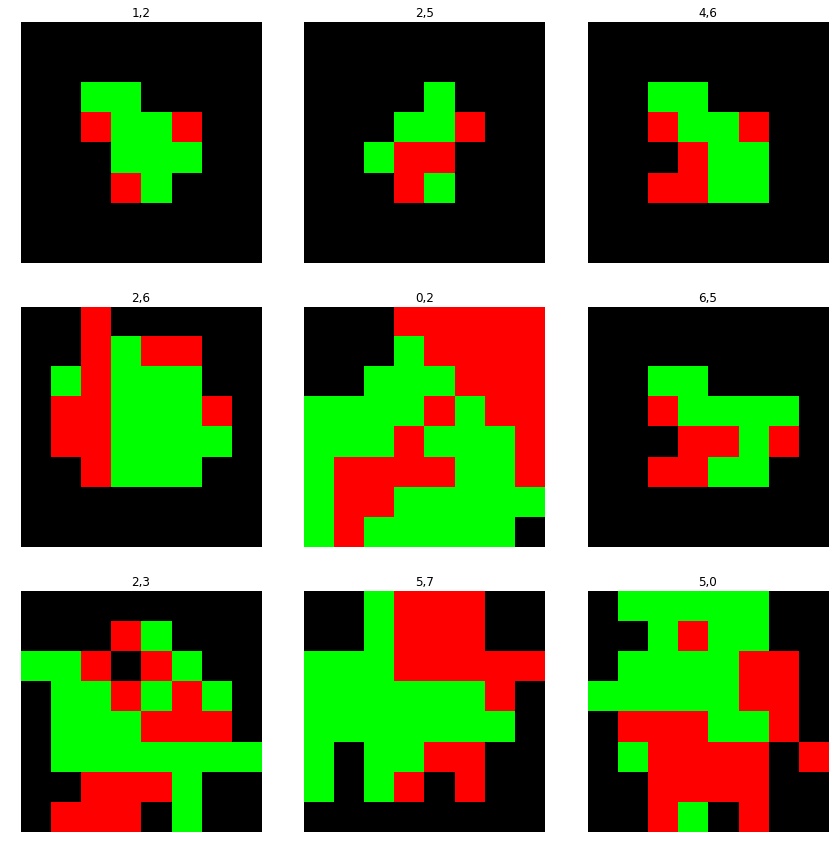

In [4]:
# Batch size
bs = 512

# Define path to images
data_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/png_boards_moves_3_chan' )

# Get a list of names of all images in folder
fnames = get_image_files( data_path )

# Define function to retrieve label from filename
def get_labels(file_path):
    file_name = file_path.name   # Get the file name (not path)
    label = file_name[:1] + ',' + file_name[1:2]        # Get the first two chars of name
    return label

# Load data into Databunch
data = ImageDataBunch.from_name_func( data_path, fnames, label_func=get_labels, bs=bs)

data.c, data.show_batch( rows = 3 )

### Build learner and plot learning rate

In [5]:
# Load model onto GPU..?
device = torch.device('cuda')
model = OthelloCNN()

# Create a learner
learn = Learner( data, model, metrics = error_rate, callback_fns=[ShowGraph, PeakMemMetric] ).to_fp16(loss_scale=512)
# learn = cnn_learner( data, models.resnet18, pretrained=False, metrics = [accuracy, error_rate], callback_fns=[ShowGraph, PeakMemMetric] ).to_fp16(loss_scale=512)

In [ ]:
# Find the optimal learning rate
lr_find( learn )
learn.recorder.plot()

In [6]:
learn.load('best_model_oth_CNN')

Learner(data=ImageDataBunch;

Train: LabelList (71859 items)
x: ImageList
Image (3, 8, 8),Image (3, 8, 8),Image (3, 8, 8),Image (3, 8, 8),Image (3, 8, 8)
y: CategoryList
1,7,2,7,2,2,7,6,2,2
Path: /users/ugrad/pretoriw/Documents/5th_Year/AI/png_boards_moves_3_chan;

Valid: LabelList (17964 items)
x: ImageList
Image (3, 8, 8),Image (3, 8, 8),Image (3, 8, 8),Image (3, 8, 8),Image (3, 8, 8)
y: CategoryList
7,3,1,7,6,6,0,4,6,1
Path: /users/ugrad/pretoriw/Documents/5th_Year/AI/png_boards_moves_3_chan;

Test: None, model=OthelloCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_

In [7]:
learn.export('trained_othello_CNN.pkl')

### Run training

epoch,train_loss,valid_loss,error_rate,cpu used,peak,gpu used,peak,time
0,2.907857,2.684932,0.741316,0,2,0,402,00:22
1,2.098510,1.981433,0.629537,0,2,0,402,00:17
2,1.761914,2.005916,0.608996,0,2,1,402,00:17
3,1.679031,2.000605,0.597584,0,2,0,402,00:17
4,1.660758,1.961881,0.612614,0,2,0,402,00:16
5,1.600700,1.976666,0.594801,0,2,0,402,00:18
6,1.471145,1.929574,0.582276,0,2,0,402,00:17
7,1.346817,1.899244,0.572757,0,2,0,402,00:16
8,1.176973,1.848394,0.562458,0,2,0,402,00:17
9,0.983725,2.008687,0.564184,0,2,0,402,00:16


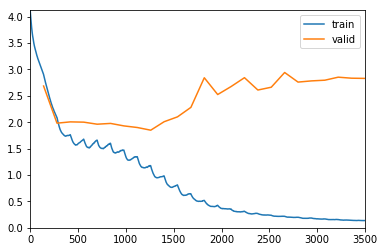

Better model found at epoch 0 with valid_loss value: 2.684932231903076.
Better model found at epoch 1 with valid_loss value: 1.9814326763153076.
Better model found at epoch 4 with valid_loss value: 1.9618810415267944.
Better model found at epoch 6 with valid_loss value: 1.9295737743377686.
Better model found at epoch 7 with valid_loss value: 1.8992441892623901.
Better model found at epoch 8 with valid_loss value: 1.8483937978744507.


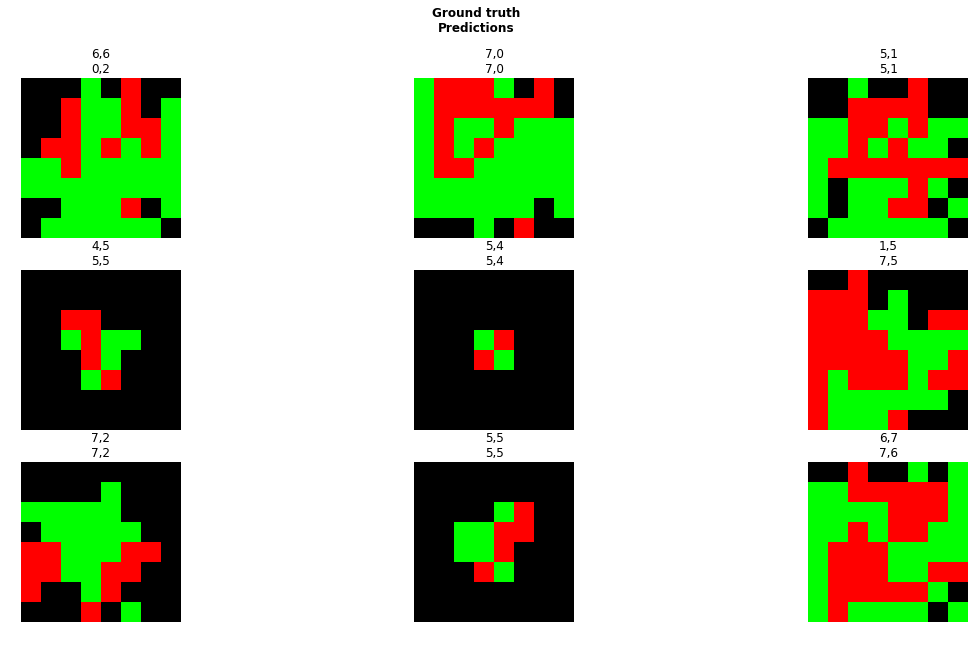

In [34]:
lr = 1e-3

learn.fit_one_cycle( 25, lr, callbacks=[SaveModelCallback(learn, name='best_model_oth_CNN') ])

learn.save( 'stage1' )
learn.load( 'stage1' )
learn.show_results( rows=3, figsize = (20, 10) )

epoch,train_loss,valid_loss,accuracy,error_rate,cpu used,peak,gpu used,peak,time
0,1.897184,2.468654,0.323313,0.676687,0,2,86,60,00:38
1,1.855012,2.472601,0.329214,0.670786,0,2,0,60,00:15
2,1.810068,2.485503,0.330661,0.669339,0,2,0,60,00:17
3,1.767647,2.506249,0.332665,0.667335,0,2,0,60,00:16
4,1.732258,2.510377,0.332554,0.667446,0,2,0,60,00:16
5,1.717695,2.521950,0.332832,0.667168,0,2,0,61,00:16
6,1.698679,2.526791,0.332053,0.667947,0,2,0,60,00:17
7,1.683986,2.529040,0.334224,0.665776,0,2,0,60,00:16
8,1.676533,2.536304,0.334057,0.665943,0,2,1,60,00:16
9,1.669061,2.530848,0.333333,0.666667,0,2,0,60,00:16


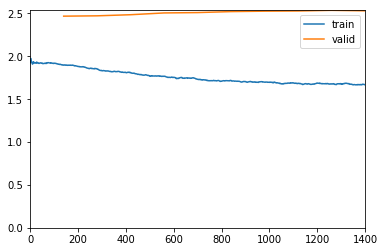

Better model found at epoch 0 with valid_loss value: 2.4686543941497803.


In [7]:
learn.load('best_model')
learn.unfreeze()
learn.fit_one_cycle( 10, slice(lr/100, lr/10), callbacks=[SaveModelCallback(learn, name='best_model')] )

### Other Cells...

In [ ]:
# # Batch size
# bs = 256

# # Define path to images
# data_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves' )

# # Get a list of names of all images in folder
# # fnames = get_image_files( data_path )
# fnames = os.listdir('/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves')
# split_idx = int(0.15 * len(fnames))

# random.shuffle(fnames)
# fnames_train = fnames[:split_idx]
# fnames_val = fnames[split_idx:]

# # Define function to retrieve label from filename
# def get_label(file_path):
#     file_name = file_path.name   # Get the file name (not path)
#     label = file_name[:2]        # Get the first two chars of name

# class NumpyDataset(Dataset):
#     def __init__(self, data_path, fnames ):
#         self.path = data_path
#         self.names = fnames
        
#     def __len__(self):
#         return len(self.names)
    
#     def __getitem__(self, idx):
#         file_path = self.path/self.names[idx]
        
#         img = np.load( file_path )
#         img = np.float32(img)
#         img = Image(img)
# #         img = torch.Tensor( img )
        
#         label = get_label( file_path )
        
#         return img, label
    
# train_dataset = NumpyDataset( data_path, fnames_train )
# val_dataset = NumpyDataset(data_path, fnames_val)

# train_dataloader = DataLoader( train_dataset, batch_size = bs)
# val_dataloader = DataLoader( val_dataset, batch_size = bs)

# data = ImageDataBunch(train_dataloader, val_dataloader)
# data.c = 60